# Análise Exploratória de Dados e Feature Engineering
Já fizemos o tratamento de missing data no notebook [missing_data.ipynb](missing_data.ipynb). Nesse notebook, faremos a Análise Exploratória de Dados.

Após o tratamento inicial dos dados, ficamos com um dataset que contém 78879 reservas feitas em um hotel localizado na cidade de Lisboa, Portugal, entre os anos de 2015 e 2017.

Nosso objetivo é prever se uma reserva será cancelada. Para isso, temos informações sobre 30 features, que podem ser vistas no dicionário de dados abaixo.

## Dicionário de dados

|variable                       |class     |description |
|:------------------------------|:---------|:-----------|
|is_canceled                    |double    | Value indicating if the booking was canceled (1) or not (0) |
|lead_time                      |double    | Number of days that elapsed between the entering date of the booking into the PMS and the arrival date |
|arrival_date_year              |double    | Year of arrival date|
|arrival_date_month             |character | Month of arrival date|
|arrival_date_week_number       |double    | Week number of year for arrival date|
|arrival_date_day_of_month      |double    | Day of arrival date|
|stays_in_weekend_nights        |double    | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
|stays_in_week_nights           |double    |  Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel|
|adults                         |double    | Number of adults|
|children                       |double    | Number of children|
|babies                         |double    |Number of babies |
|meal                           |character | Type of meal booked. Categories are presented in standard hospitality meal packages: <br> Undefined/SC – no meal package;<br>BB – Bed & Breakfast; <br> HB – Half board (breakfast and one other meal – usually dinner); <br> FB – Full board (breakfast, lunch and dinner) |
|country                        |character | Country of origin. Categories are represented in the ISO 3155–3:2013 format |
|market_segment                 |character | Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
|distribution_channel           |character | Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
|is_repeated_guest              |double    | Value indicating if the booking name was from a repeated guest (1) or not (0) |
|previous_cancellations         |double    | Number of previous bookings that were cancelled by the customer prior to the current booking |
|previous_bookings_not_canceled |double    | Number of previous bookings not cancelled by the customer prior to the current booking |
|reserved_room_type             |character | Code of room type reserved. Code is presented instead of designation for anonymity reasons |
|assigned_room_type             |character | Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons |
|booking_changes                |double    | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation|
|deposit_type                   |character | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:<br>No Deposit – no deposit was made;<br>Non Refund – a deposit was made in the value of the total stay cost;<br>Refundable – a deposit was made with a value under the total cost of stay. |
|agent                          |character | ID of the travel agency that made the booking |
|company                        |character | ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons |
|days_in_waiting_list           |double    | Number of days the booking was in the waiting list before it was confirmed to the customer |
|customer_type                  |character | Type of booking, assuming one of four categories:<br>Contract - when the booking has an allotment or other type of contract associated to it;<br>Group – when the booking is associated to a group;<br>Transient – when the booking is not part of a group or contract, and is not associated to other transient booking;<br>Transient-party – when the booking is transient, but is associated to at least other transient booking|
|adr                            |double    | Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights |
|required_car_parking_spaces    |double    | Number of car parking spaces required by the customer |
|total_of_special_requests      |double    | Number of special requests made by the customer (e.g. twin bed or high floor)|
|reservation_status             |character | Reservation last status, assuming one of three categories:<br>Canceled – booking was canceled by the customer;<br>Check-Out – customer has checked in but already departed;<br>No-Show – customer did not check-in and did inform the hotel of the reason why |
|reservation_status_date        |double    | Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel|

fonte: dicionário adaptado do repo que contém o dataset, https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-02-11

In [1]:
#importando as bibliotecas:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#importando os dados:
df = pd.read_csv('hotels_tratado.csv')

## IsCanceled, nossa variável dependente

In [2]:
#distribuição da nossa variável dependente
df.IsCanceled.value_counts()

0    45831
1    33048
Name: IsCanceled, dtype: int64

Vemos acima que temos cerca de 46 mil reservas que não foram canceladas e cerca de 33 mil reservas que foram canceladas. Cerca de 41% das reservas são canceladas! Temos um grande potencial de impacto no negócio se usarmos os insights obtidos com data science para diminuir esse percentual.

Para entender melhor o que é uma reserva cancelada, plotamos abaixo a contagem de reservas canceladas e não canceladas contra os 3 tipos de status de uma reserva: check-out, canceled e no-show.

Mais abaixo, Fazemos também um pivot table com a contagem de reservas canceladas.

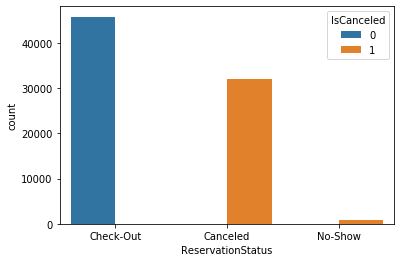

In [3]:
sns.countplot('ReservationStatus', data=df, hue='IsCanceled')
plt.show()

In [4]:
pd.pivot_table(df, index=['ReservationStatus'], values=['IsCanceled'], aggfunc=np.sum)

,IsCanceled
ReservationStatus,
Canceled,32140
Check-Out,0
No-Show,908


Vemos acima que uma reserva é marcada como cancelada sempre que o status da reserva é 'canceled' ou 'no-show'. A reserva é marcada como não cancelada (IsCanceled=0) somente quando o cliente comparece ao hotel e faz seu check-out ao ir embora.

Perceba que a coluna 'ReservationStatus' determina completamente se a reserva foi cancelada ou não. **Entretanto, não podemos usá-la em nosso modelo, pois seria um tipo de data leakage**: quando o modelo for colocado em produção, ele tentará prever se a reserva será cancelada ANTES de termos a informação sobre o 'ReservationStatus'. O mesmo vale para a coluna 'ReservationStatusDate' e para a coluna 'AssignedRoomType' (pois não sabemos que quarto será dado ao hóspede até que ele apareça para fazer o check-in).

Para evitar o data leakage, vamos eliminar esses duas colunas de nossa análise.

In [5]:
#eliminando ReservationStatus e ReservationStatusDate para evitar data leakage
df.drop(['ReservationStatus', 'ReservationStatusDate', 'AssignedRoomType'], axis=1, inplace=True)

## Variáveis independentes (nossas features)
### Lead Time
O leadtime conta a quantidade de dias entre a reserva e a data da estadia.

Reservas que não são canceladas costumam ter um lead time menor, como mostra o boxplot abaixo. Parece que essa feature será útil para o modelo.

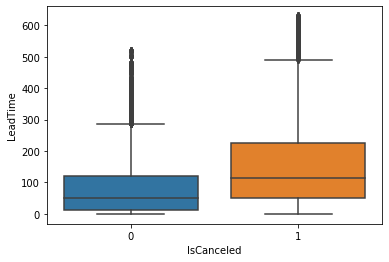

In [6]:
sns.boxplot(x='IsCanceled', y='LeadTime', data=df)

### Mês e semana da reserva

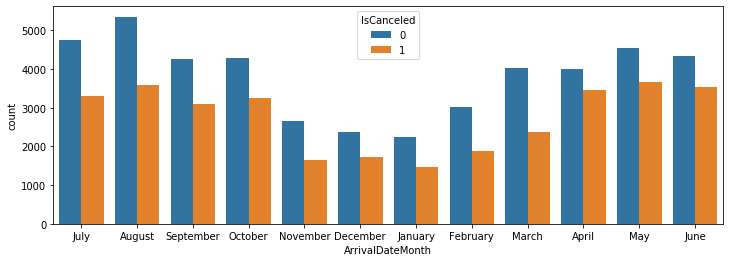

In [7]:
#contagem de cancelamentos em cada mês
fig, ax = plt.subplots(figsize=(12,4))

sns.countplot('ArrivalDateMonth', data=df, hue='IsCanceled', ax=ax)

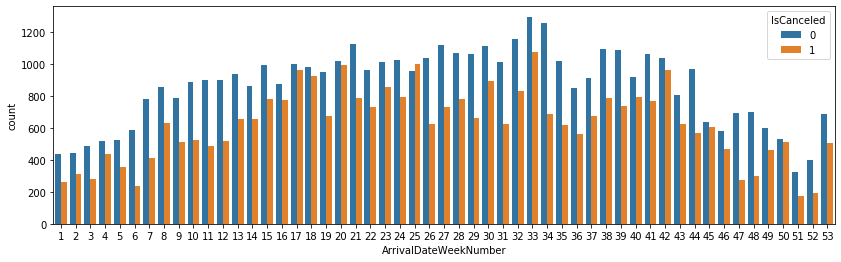

In [8]:
#contagem de cancelamentos em cada semana do ano
fig, ax = plt.subplots(figsize=(14,4))

sns.countplot('ArrivalDateWeekNumber', data=df, hue='IsCanceled', ax=ax)

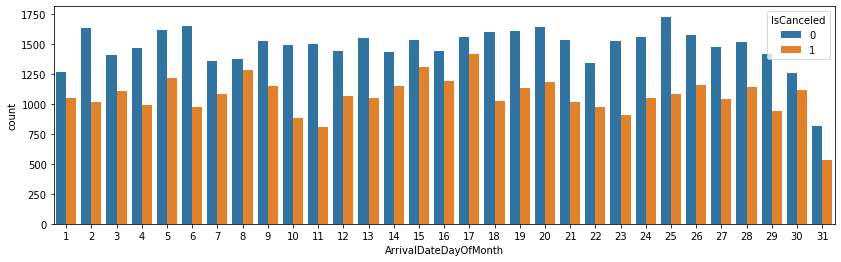

In [9]:
#contagem de cancelamentos em cada dia do mês
fig, ax = plt.subplots(figsize=(14,4))

sns.countplot('ArrivalDateDayOfMonth', data=df, hue='IsCanceled', ax=ax)

Plotamos acima a contagem de cancelamentos em cada mês, em casa semana do ano e em cada dia do mês. Devemos tomar cuidado, entretanto, ao usar esses gráficos para avaliar a influência dessas features na probabilidade de cancelamento da reserva, pois uma maior contagem de cancelamentos pode acontecer simplesmente porque temos mais reservas totais naquele mês, semana ou dia. Por exemplo, em agosto temos mais de 2x mais reservas em comparação com janeiro, em média.

Para evitar esse problema, **plotamos abaixo o percentual de cancelamentos** em cada mês, cada semana do ano e cada dia do mês. O percentual de cancelamentos, ao invés da contagem de cancelamentos, pode nos dar um indício maior se uma possível influência do mês na probabilidade de uma reserva ser cancelada.

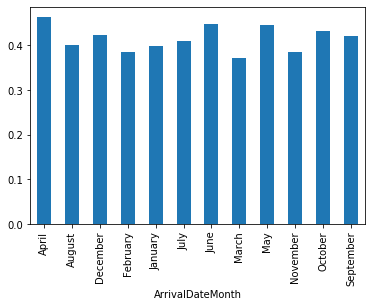

In [10]:
df.groupby('ArrivalDateMonth').agg('mean').IsCanceled.plot.bar()

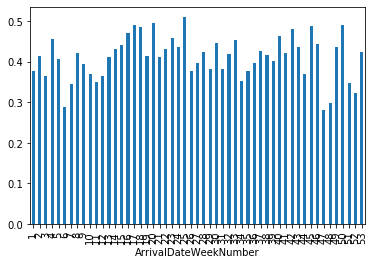

In [11]:
df.groupby('ArrivalDateWeekNumber').agg('mean').IsCanceled.plot.bar()

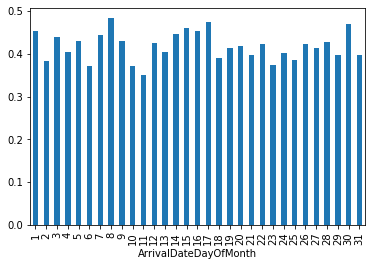

In [12]:
df.groupby('ArrivalDateDayOfMonth').agg('mean').IsCanceled.plot.bar()

O mês da reserva não parece ter grande influência na probabilidade de cancelamento da reserva. O mesmo vale para a semana ao longo do ano, e o dia do mês.

### Quantidade de dias na reserva
#### Quantidade de dias durante a semana (exclui os dias de final de semana)
Pelo mesmo motivo acima, plotamos a contagem e o percentual de cancelamentos, em função da quantidade de dias de semana que a reserva possui.

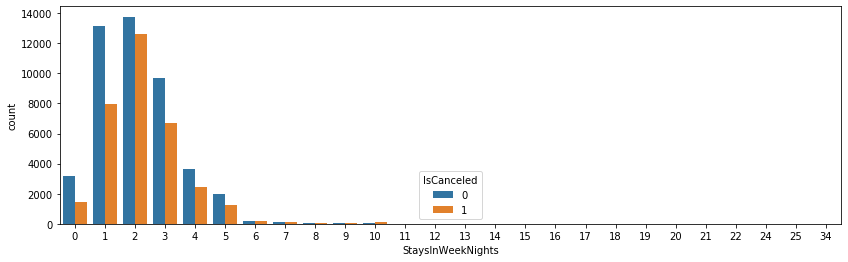

In [13]:
fig, ax = plt.subplots(figsize=(14,4))

sns.countplot('StaysInWeekNights', data=df, hue='IsCanceled', ax=ax)

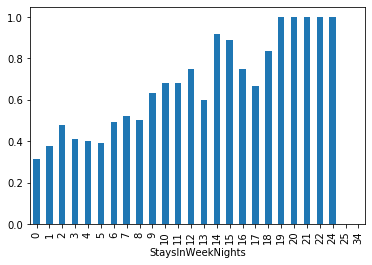

In [14]:
df.groupby('StaysInWeekNights').agg('mean').IsCanceled.plot.bar()

Pelo gráfico acima, vemos que reservas que possuem mais do que 5 ou 6 dias de semana parecem ter uma maior probabilidade de cancelamento.

Entretanto, menos de 2% das reservas possuem mais de 5 dias durante a semana. Logo, essa variável deve ser útil apenas nesse pequeno percentual de casos.

Além disso, percebe-se que reservas que possuem 0 dias durante a semana (i.e., só possuem dias de final de semana) apresentaram um percentual menor de cancelamentos, de aproximadamente 32%, enquanto que reservas que possuem dias durante a semana apresentam maior percentual de cancelamentos: 1 dia durante a semana (38%), 2 dias na semana (48%), 3 dias na semana (41%), etc.

Isso sugere que façamos um feature engineering, criando a coluna isOnlyWeekend, que diz se a reserva possui somente dias de final de semana (isOnlyWeekend=1) ou se possui algum dia durante a semana (isOnlyWeekend=0). Faremos esse feature engineering mais adiante.

#### Quantidade de dias durante o final de semana
Repetimos a análise acima, mas agora em função do número de dias de final de semana na reserva

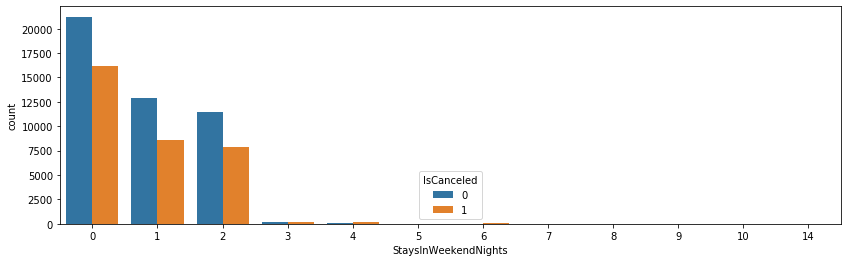

In [15]:
fig, ax = plt.subplots(figsize=(14,4))

sns.countplot('StaysInWeekendNights', data=df, hue='IsCanceled', ax=ax)

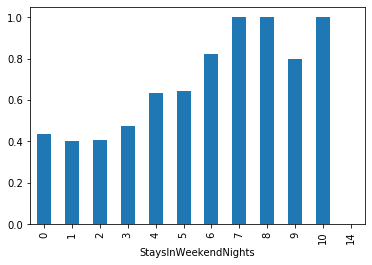

In [16]:
df.groupby('StaysInWeekendNights').agg('mean').IsCanceled.plot.bar()

Para o número de dias de final de semana, obtivemos um efeito parecido com aquele observado no número de dias de semana. O percentual de cancelamento é maior em reservas com mais de 3 dias de final de semana. Mas isso acontece em menos de 1% das reservas (para ter 3 dias em finais de semana a reserva deve ter duração de mais de mais de 7 dias). Logo, essa feature deve ser útil apenas nesse pequeno percentual de casos.

#### Feature Engineering
Como percebemos que o percentual de cancelamentos em reservas que só possuem dias de final de semana é menor que reservas que possuem algum dia durante a semana, vamos criar a feature isOnlyWeekend. Ela terá o valor de 1 caso a reserva só possua dias de final de semana, e 0 caso possua algum dia durante a semana.

Em seguida, plotamos a contagem e o percentual de cancelamentos para cada valor dessa nova feature.

In [17]:
#criando a feature isOnlyWeekend e adicionando ao nosso dataframe
isOnlyWeekendSeries = df.StaysInWeekNights.apply(lambda x: 1 if x == 0 else 0)
isOnlyWeekendSeries.name = 'isOnlyWeekend'
df = pd.concat([df,isOnlyWeekendSeries], axis=1)

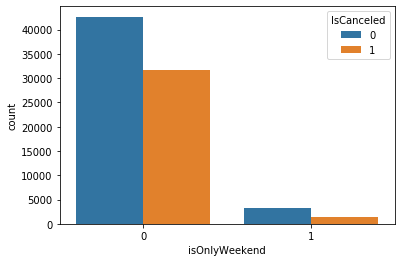

In [18]:
sns.countplot('isOnlyWeekend', data=df, hue='IsCanceled')

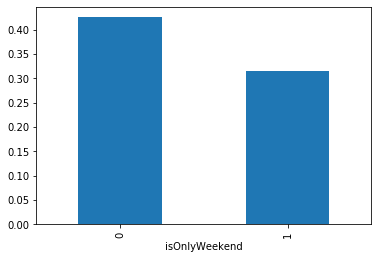

In [19]:
df.groupby('isOnlyWeekend').agg('mean').IsCanceled.plot.bar()

O percentual de cancelamentos é de 31% quando isOnlyWeekend = 1 (reserva somente com dias de final de semana), e de 42% quando isOnlyWeekend = 0 (reserva inclui dias de semana).

Por isso, acredito que essa variável será importante na previsão da probabilidade de cancelamento por nosso modelo.

### Quantidade de Adultos
Vemos abaixo que o percentual de cancelamento em reservas de 2 adultos (44%) é maior que com outra quantidade de adultos, por exemplo 1 adulto (34%). Provavelmente essa feature será útil na previsão da probabilidade de cancelamento.

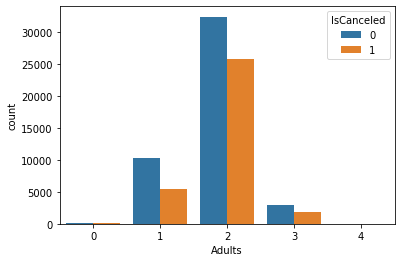

In [20]:
sns.countplot(x='Adults', hue='IsCanceled', data=df)

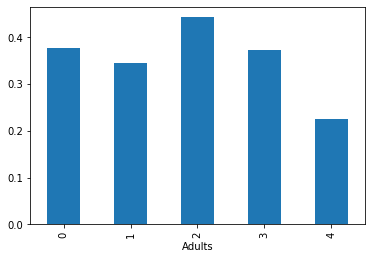

In [21]:
df.groupby('Adults').agg('mean').IsCanceled.plot.bar()

### Quantidade de crianças
Cerca de 7% das reservas possuem crianças. Quando isso acontece, o percentual de cancelamentos é menor. Por exemplo, o percentual de cancelamento em reservas sem crianças foi de 42%, enquanto que com 1 criança foi de 33%. Acredito que essa feature será útil para o modelo, nesses casos.

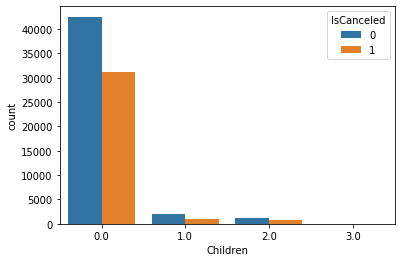

In [22]:
sns.countplot(x='Children', hue='IsCanceled', data=df)

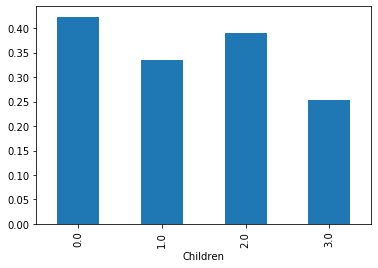

In [23]:
df.groupby('Children').agg('mean').IsCanceled.plot.bar()

### Quantidade de bebês
Somente 0,5% das reservas tinham bebês. Nesses casos, o percentual de cancelamento caiu mais da metade, de 42% para 18%. Acredito que essa feature será útil, nesses casos isolados.

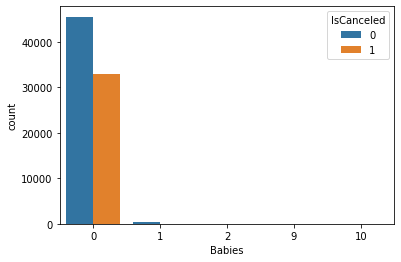

In [24]:
sns.countplot(x='Babies', hue='IsCanceled', data=df)

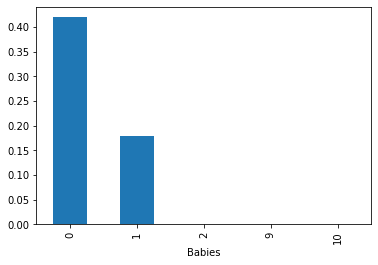

In [25]:
df.groupby('Babies').agg('mean').IsCanceled.plot.bar()

### Tipo de refeição
Cerca de 77% das reservas incluem somente café da manhã (BB). Nesse caso, o percentual de cancelamentos foi de 43%.

Cerca de 0,5% das reservas eram Full Board (café da manhã, almoço e jantar). Dessas, 80% foram canceladas.

Nos outros casos (HB e SC - ver dicionário de dados), o percentual de cancelamento caiu para 38%.

Como existe uma diferença de cerca de 5% no percentual de cancelamentos entre as reservas com BB e as demais, acredito que essa feature será relevante para o modelo.

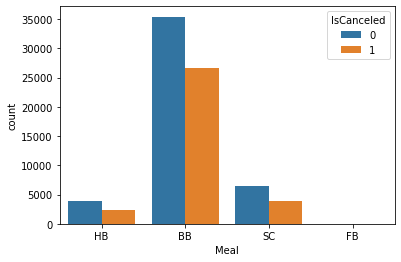

In [26]:
sns.countplot(x='Meal', hue='IsCanceled', data=df)

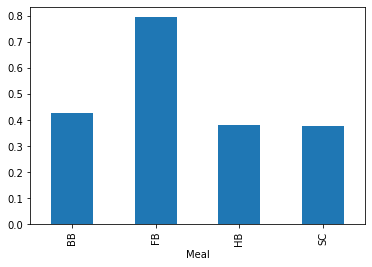

In [27]:
df.groupby('Meal').agg('mean').IsCanceled.plot.bar()

### Country
Temos 166 países diferentes em nosso dataset. Mas desses, 131 possuem menos de 100 reservas (0,1% do total, cada) no dataset. Assim, não acredito que seja interessante trabalhar diretamente com todas as diferentes nacionalidades, pois vai aumentar de forma significativa o custo computacional de treinamento do modelo, e provavelmente não traria grande incremento de acurácia.

Um fator relevante para o cancelamento da reserva é a facilidade com que o cliente consegue chegar ao hotel. Influenciam isso distância entre o cliente e o hotel e a facilidade que o hóspede tem de entrar em Portugal, por questões políticas. Logo, surgem ideias para feature engineering:
- O hóspede é de Portugal (mesmo país do hotel)? (feature tipo boolean)
- O país de origem do cliente pertence à União Europeia (excluindo Portugal)? (feature tipo boolean)


Como não temos a informação da cidade do hóspede, somente do país, não seria possível calcular a distância do hóspede até o hotel. Teríamos que usar algum ponto de seu país, como a capital, o que traria incertezas à análise. Portanto, ficarei satisfeito em criar somente as duas primeiras features.

In [28]:
#lista de países da União Europeia
EU_list = "PRT GBR	AUT	BEL	BGR	HRV	CYP	CZE	DNK	EST	FIN	FRA	DEU	GRC	HUN	IRL	ITA	LVA	LTU	LUX	MLT	NLD	POL	ROU	SVK	SVN	ESP	SWE".split()

#criando a feature isEU (1 para países da União Europeia, 0 se não)
df["isEU"] = df.Country.apply(lambda x: 1 if x in EU_list else 0)

#criando a feature isPRT (1 se o país é Portugal, 0 se não)
df["isPRT"] = df.Country.apply(lambda x: 1 if x == 'PRT' else 0)

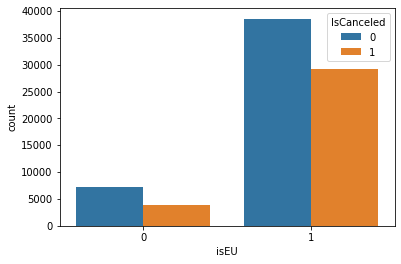

In [29]:
sns.countplot(x='isEU', hue='IsCanceled', data=df)

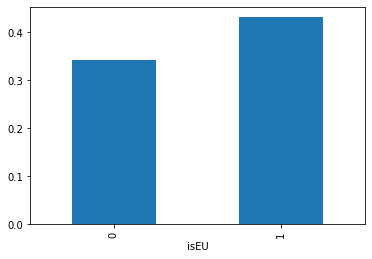

In [30]:
df.groupby('isEU').agg('mean').IsCanceled.plot.bar()

In [31]:
df[df.Country != 'PRT'].groupby('isEU').agg('mean').IsCanceled

isEU
0    0.343417
1    0.247121
Name: IsCanceled, dtype: float64

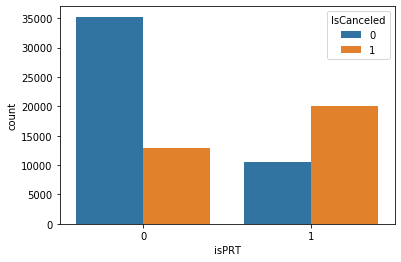

In [32]:
sns.countplot(x='isPRT', hue='IsCanceled', data=df)

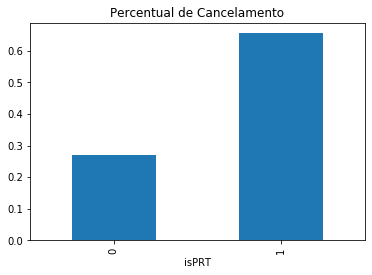

In [98]:
fig, ax = plt.subplots()
plt.title('Percentual de Cancelamento')

df.groupby('isPRT').agg('mean').IsCanceled.plot.bar()

fig.savefig("isPRT_cancel.png", bbox_inches='tight', dpi=300)

In [34]:
df.groupby('isPRT').agg('mean').IsCanceled

isPRT
0    0.269224
1    0.654817
Name: IsCanceled, dtype: float64

Analisando as novas features criadas, observamos que a taxa de cancelamentos de reservas é de:
- 65% se o país do cliente é Portugal e 27% quando não é
- 43% se o país é da União Europeia e 34% quando não é
- 24% se o país é da União Europeia, mas não é Portugal

Assim, observamos que uma reserva feita por um cliente da União Europeia que não seja Portugal tem um percentual de cancelamentos equivalente a cerca de 1/3 do percentual de cancelamentos de uma reserva feita por um cliente de Portugal.

Quando a reserva é feita de fora da União Europeia, o percentual de cancelamento é quase a metade de comparada com uma reserva feita de Portugal.

Acredito que as features criadas acima, isEU e isPRT, serão muito importantes para nosso modelo de previsão da probabilidade de cancelamento.

### MarketSegment
Essa feature parece diferenciar bem a probabilidade de cancelamento da reserva. Por exemplo, cerca de 17% das reservas são do MarketSegment 'groups', onde observamos um percentual de cancelamento de 69%, bem maior que as outras categorias.

Acredito que essa feature será importante para nosso modelo.

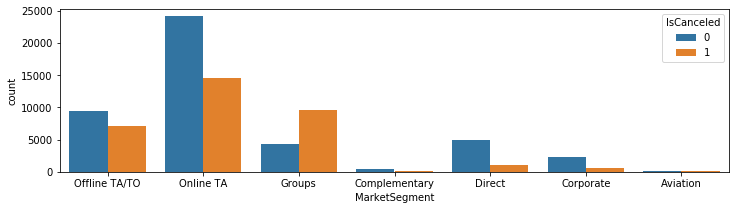

In [35]:
fig, ax = plt.subplots(figsize=(12,3))


sns.countplot(x='MarketSegment', hue='IsCanceled', data=df, ax=ax)

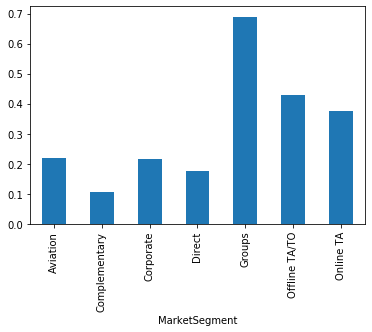

In [36]:
df.groupby('MarketSegment').agg('mean').IsCanceled.plot.bar()

### DistributionChannel
Cerca de 85% dos DistributionChannel são TA/TO. Nesse caso, o percentual de cancelamentos é mais que o dobro, se comparado com qualquer outra categoria de DistributionChannel.

Logo, essa variável também deve ser útil para o modelo.

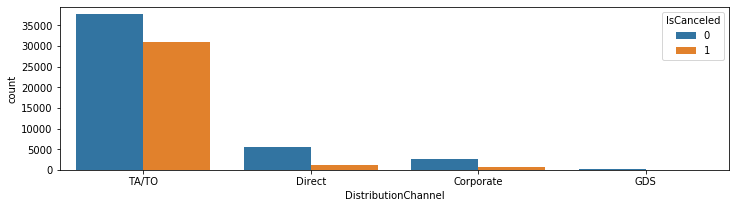

In [37]:
fig, ax = plt.subplots(figsize=(12,3))


sns.countplot(x='DistributionChannel', hue='IsCanceled', data=df, ax=ax)

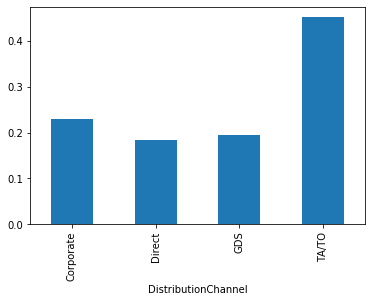

In [38]:
df.groupby('DistributionChannel').agg('mean').IsCanceled.plot.bar()

### IsRepeatedGuest
Cerca de 98% das reservas são de clientes que nunca se hospedaram no hotel. Mas quando o cliente já se hospedou alguma outra vez no hotel, o percentual de cancelamento é cerca de 2x menor.

Logo, essa feature deve ser bastante útil nesse segundo caso.

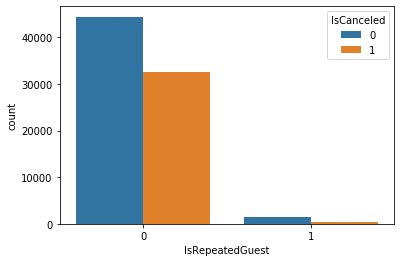

In [39]:
sns.countplot(x='IsRepeatedGuest', hue='IsCanceled', data=df)

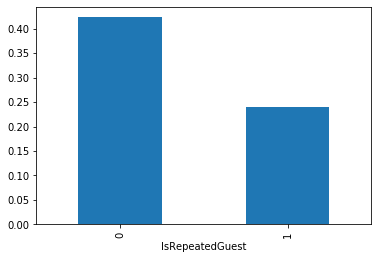

In [40]:
df.groupby('IsRepeatedGuest').agg('mean').IsCanceled.plot.bar()

### PreviousCancellations
Cerca de 92% das reservas foram feitas por pessoas que nunca cancelaram reservas nesse hotel. Entre elas, o percentual de cancelamento foi de 38%.

Outras 6% das reservas foram feitas por pessoas que já haviam cancelado uma vez reserva. Entre elas, o percentual de cancelamento subiu para 96%.

Essa diferença gritante no percentual de cancelamentos entre os dois grupos indica que essa feature será útil para o modelo, principalmente nos casos em que a reserva for feita por alguém que já cancelou uma vez antes.

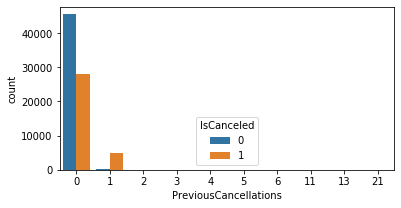

In [41]:
fig, ax = plt.subplots(figsize=(6,3))

sns.countplot(x='PreviousCancellations', hue='IsCanceled', data=df, ax=ax)

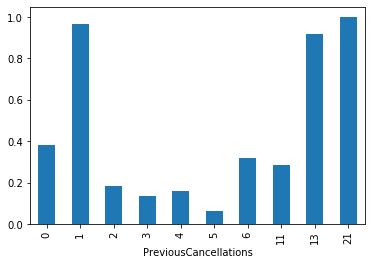

In [42]:
df.groupby('PreviousCancellations').agg('mean').IsCanceled.plot.bar()

### PreviousBookingsNotCanceled
PreviousBookingsNotCanceled mede quantas reservas que não foram canceladas já foram feitas pelo cliente.
98% das reservas tinham PreviousBookingsNotCanceled = 0, e mostraram um percentual de cancelamento de 43%.

Já os 2% que **não** tinham PreviousBookingsNotCanceled = 0 tiveram um percentual de cancelamento bem inferior.

Desse modo, acredito que essa feature será relevante para o modelo, principalmente quando tivermos PreviousBookingsNotCanceled diferente de 0.

In [43]:
#temos quantas reservas para cada valor de PreviousBookingsNotCanceled ?
df.PreviousBookingsNotCanceled.value_counts()

0     77306
1       559
2       192
3       128
4       102
      ...  
47        1
36        1
49        1
50        1
63        1
Name: PreviousBookingsNotCanceled, Length: 73, dtype: int64

In [44]:
#qual é o percentual de cancelamentos para cada valor de PreviousBookingsNotCanceled ?
df.groupby('PreviousBookingsNotCanceled').agg('mean').IsCanceled

PreviousBookingsNotCanceled
0     0.425944
1     0.078712
2     0.062500
3     0.062500
4     0.088235
        ...   
68    0.000000
69    0.000000
70    0.000000
71    0.000000
72    0.000000
Name: IsCanceled, Length: 73, dtype: float64

### ReservedRoomType
Cerca de 77% das reservas eram no quarto tipo A, e mostraram um percentual de cancelamentos de 44%. Cerca de 15% das reservas eram no quarto tipo D, e mostraram um percentual de cancelamentos de 35%, que é 9% menor.

Por isso, acredito que essa variável tenha uma influência relevante para nosso modelo.

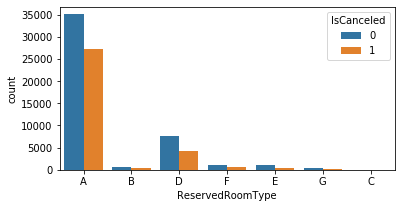

In [45]:
fig, ax = plt.subplots(figsize=(6,3))

sns.countplot(x='ReservedRoomType', hue='IsCanceled', data=df, ax=ax)

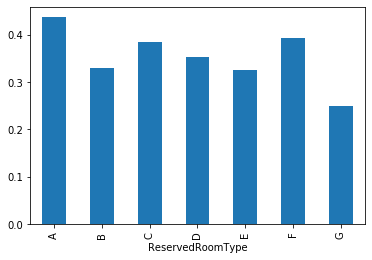

In [46]:
df.groupby('ReservedRoomType').agg('mean').IsCanceled.plot.bar()

### BookingChanges
Vemos abaixo que quando o cliente faz uma alteração na reserva, é muito menos provável que ele cancele a reserva.

Cerca de 86% das reservas não tiveram alteração, e o percentual de cancelamentos foi de 46%. Cerca de 9% das reservas tiveram 1 alteração, e o percentual de cancelamentos foi de apenas 14%! O percentual de cancelamentos diminui mais de 3x caso uma alteração tenha sido feita na reserva. Por isso, acredito que essa feature sejá útil para o modelo.

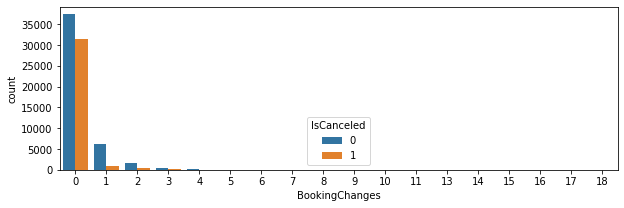

In [47]:
fig, ax = plt.subplots(figsize=(10,3))

sns.countplot(x='BookingChanges', hue='IsCanceled', data=df, ax=ax)

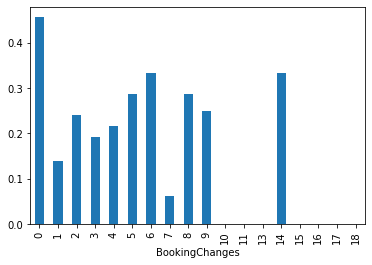

In [48]:
df.groupby('BookingChanges').agg('mean').IsCanceled.plot.bar()

### DepositType
Essa feature me deixou muito surpreso. 

Existem 3 categorias de DepositType: No Deposit, Non Refund e Refundable.

Levando em consideração o nome da categoria, eu esperava que Non Refund se referisse a reservas não reembolsáveis. Fiquei chocado ao descobrir que esse tipo de reserva, que representa cerca de 16% do total, apresentou uma taxa de cancelamento de 99,8%. Seria muito estranho que a quase totalidade dos clientes que pagam uma taxa não reembolsável pela reserva acabassem cancelando-a e perdendo seu dinheiro.

Após pesquisar na [documentação do dataset](https://www.sciencedirect.com/science/article/pii/S2352340918315191), vi que os nomes das categorias induzem ao erro. A interpretação correta de cada categoria de DepositType é a seguinte:
- Non Refund: um depósito foi feito no valor do custo total da estadia, ou superior.
- No Deposit: nenhum depósito foi feito.
- Refundable: um depósito foi feito em valor inferior ao custo total da estadia.

Assim, de acordo com a documentação do dataset, as categorias são definidas pelo valor do depósito, e não pela propriedade de o depósito ser reembolsável ou não reembolsável.

Ainda assim, me parece muito estranho que 99,8% dos clientes que pagaram o valor total da estadia para fazer a reserva tenham acabado por cancelá-la (mesmo reavendo seu dinheiro), enquanto que apenas 31% dos clientes que não fizeram nenhum depósito acabaram cancelando a reserva. O ideal seria conversar com o pessoal do hotel para entender melhor essas categorias.

Enquanto não podemos tirar essa dúvida com o pessoal do hotel, parece que essa feature vai ser de extrema importância para nosso modelo, uma vez que o percentual de cancelamento é próximo de 100% para a categoria Non Refund.

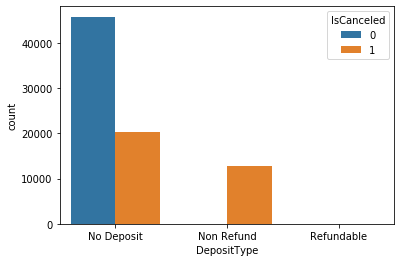

In [49]:
sns.countplot(x='DepositType', hue='IsCanceled', data=df)

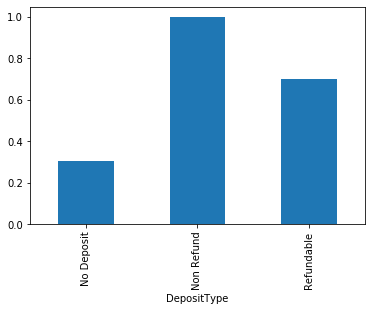

In [50]:
df.groupby('DepositType').agg('mean').IsCanceled.plot.bar()

### Agent
Como temos um grande número de Agents com pouquíssimas reservas, não vamos trabalhar com todos eles para não encarecer demais o custo computacional de treinamento do modelo. Vamos utilizar somente aqueles com pelo menos 100 reservas.

Cerca de 87% das reservas estão relacionadas a Agents que possuem pelo menos 100 reservas no dataset. Entre eles, o percentual de cancelamento varia de 1% a 95%. Por exemplo, cerca de 40% das reservas são do Agent 9, com proporção de cancelamento de 42%.

Como temos uma grande diferença no percentual de cancelamento entre os diferentes Agents, acredito que essa será uma variável importante para o modelo.

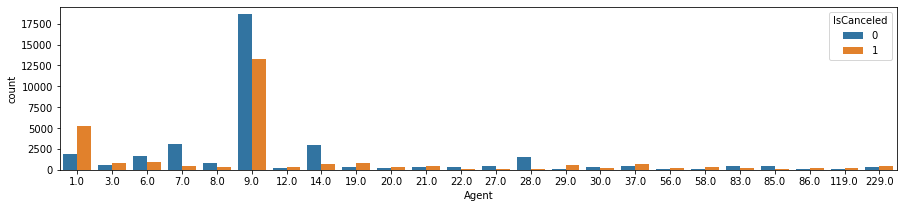

In [51]:
fig, ax = plt.subplots(figsize=(15,3))

#pegando somente os agents que possuem pelo menos 100 reservas no dataset
x = df.Agent.value_counts()
y = df[df.Agent.isin(x[x>300].index)]

#plotando
sns.countplot(x='Agent', hue='IsCanceled', data=y, ax=ax)

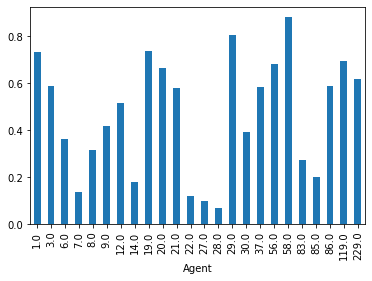

In [52]:
y.groupby('Agent').agg('mean').IsCanceled.plot.bar()

In [53]:
#criando uma lista com as categorias dos Agent's que possuem pelo menos 100 reservas
min_reservas = 100
x = df.Agent.value_counts()
index_list = x[x>min_reservas].index.tolist()

#criando uma coluna em que preservamos as categorias dos agents acima. Todos os outros (inclusive os nulos) ficam com valor de 0
df["Agent_top"] = df.Agent.apply(lambda x: str(int(x)) if x in index_list else '0')

### DaysInWaitingList
Essa não me parece uma boa feature para ser usada na modelagem. Ela mede o número de dias na lista de espera antes da reserva ser confirmada ao cliente. Cerca de 97% das reservas são confirmadas em menos de 1 dia (DaysInWaitingList = 0). Das reservas que não são confirmadas no mesmo dia, a maior parte delas é confirmada muito tempo depois (mais de 30 dias). Acredito que isso seja uma coisa muito difícil de medir em produção. Se a reserva demorou tanto tempo para ser confirmada ao cliente, provavelmente não havia muito o que o hotel pudesse fazer.

In [54]:
df.DaysInWaitingList.value_counts()

0      75440
39       226
58       164
44       140
31       127
       ...  
72         1
73         1
117        1
74         1
81         1
Name: DaysInWaitingList, Length: 114, dtype: int64

### CustomerType

Temos quatro tipos de clientes. As proporções de reservas canceladas foram entre os dois tipos mais frequentes foram bastante diferentes: 46% do Transient contra 28% do Transient-Party.

Desse modo, acredito que essa feature será importante para nosso modelo.

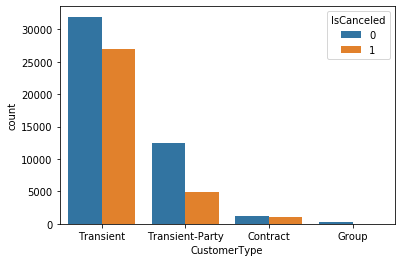

In [55]:
sns.countplot(x='CustomerType', hue='IsCanceled', data=df)

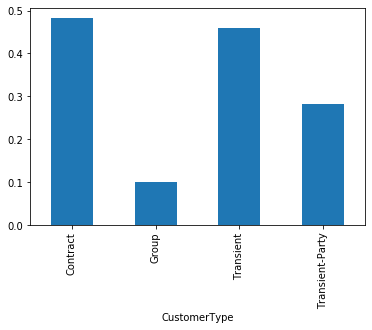

In [56]:
df.groupby('CustomerType').agg('mean').IsCanceled.plot.bar()

### ADR
O ADR mede o preço médio da diária de hospedagem.

Observando a distribuição de valores, não parece haver diferença significa de valores diários de hospedagem entre reservas canceladas e não canceladas. Desse modo, acredito que essa feature não será das mais relevantes para o modelo.

[(0, 300)]

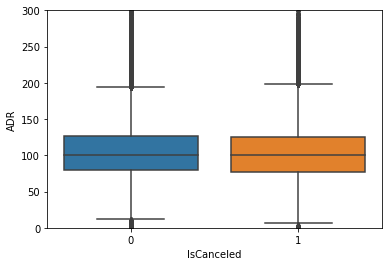

In [57]:
#ax.set(ylim=(10, 40))

#sns.boxplot(x='IsCanceled', y='ADR', data=df)

ax = sns.boxplot(x="IsCanceled", y="ADR", data=df)
ax.set(ylim=(0, 300))

### RequiredCarParkingSpaces
Nenhuma das 1918 reservas (cerca de 2,5% do total de reservas) que requeriram alguma vaga para carro foi cancelada. Entre as reservas que não requereram vaga para carro, a proporção de cancelamento foi de 43%.

Logo, acredito que essa seja uma feature bastante útil para o modelo no caso de uma reserva ser feita requerendo vaga de carro.

In [58]:
df.RequiredCarParkingSpaces.value_counts()

0    76961
1     1913
2        3
3        2
Name: RequiredCarParkingSpaces, dtype: int64

In [59]:
df.groupby('RequiredCarParkingSpaces').agg('mean').IsCanceled

RequiredCarParkingSpaces
0    0.429412
1    0.000000
2    0.000000
3    0.000000
Name: IsCanceled, dtype: float64

### TotalOfSpecialRequests
Reservas que possuem algum pedido especial são muito menos prováveis de serem canceladas!

Cerca de 60% das reservas não possuíam pedidos especiais, e a proporção de cancelamento foi de 55%. Já para os 37% de reservas que possuíam um ou dois pedidos especiais, a proporção de cancelamento foi cerca de 22%.

Por isso, acredito que essa feature seja muito importante para o modelo!

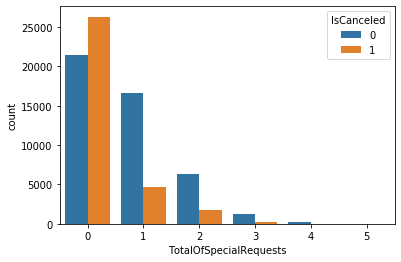

In [60]:
sns.countplot(x='TotalOfSpecialRequests', hue='IsCanceled', data=df)

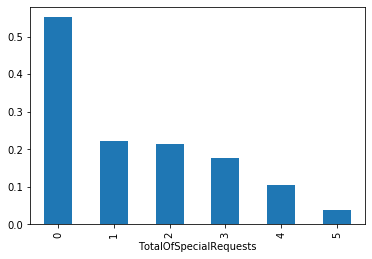

In [61]:
df.groupby('TotalOfSpecialRequests').agg('mean').IsCanceled.plot.bar()

In [62]:
df.TotalOfSpecialRequests.value_counts()

0    47676
1    21294
2     8103
3     1582
4      198
5       26
Name: TotalOfSpecialRequests, dtype: int64

In [63]:
df.groupby('TotalOfSpecialRequests').agg('mean').IsCanceled

TotalOfSpecialRequests
0    0.551619
1    0.221236
2    0.214365
3    0.176359
4    0.106061
5    0.038462
Name: IsCanceled, dtype: float64

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78879 entries, 0 to 78878
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   78879 non-null  int64  
 1   LeadTime                     78879 non-null  int64  
 2   ArrivalDateYear              78879 non-null  int64  
 3   ArrivalDateMonth             78879 non-null  object 
 4   ArrivalDateWeekNumber        78879 non-null  int64  
 5   ArrivalDateDayOfMonth        78879 non-null  int64  
 6   StaysInWeekendNights         78879 non-null  int64  
 7   StaysInWeekNights            78879 non-null  int64  
 8   Adults                       78879 non-null  int64  
 9   Children                     78879 non-null  float64
 10  Babies                       78879 non-null  int64  
 11  Meal                         78879 non-null  object 
 12  Country                      78879 non-null  object 
 13  MarketSegment   

In [65]:
#pegando somente as colunas que serão usadas na modelagem
df_model = df.drop(['ArrivalDateYear', 'Country', 'Agent', 'DaysInWaitingList'], axis=1)

#exportando o dataset com dados para modelagem
df_model.to_csv('hotels_model_data.csv', index=False)